/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/pbilko/miniconda3/envs/PP/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Episode 1 

Epis

TypeError: can only concatenate list (not "float") to list

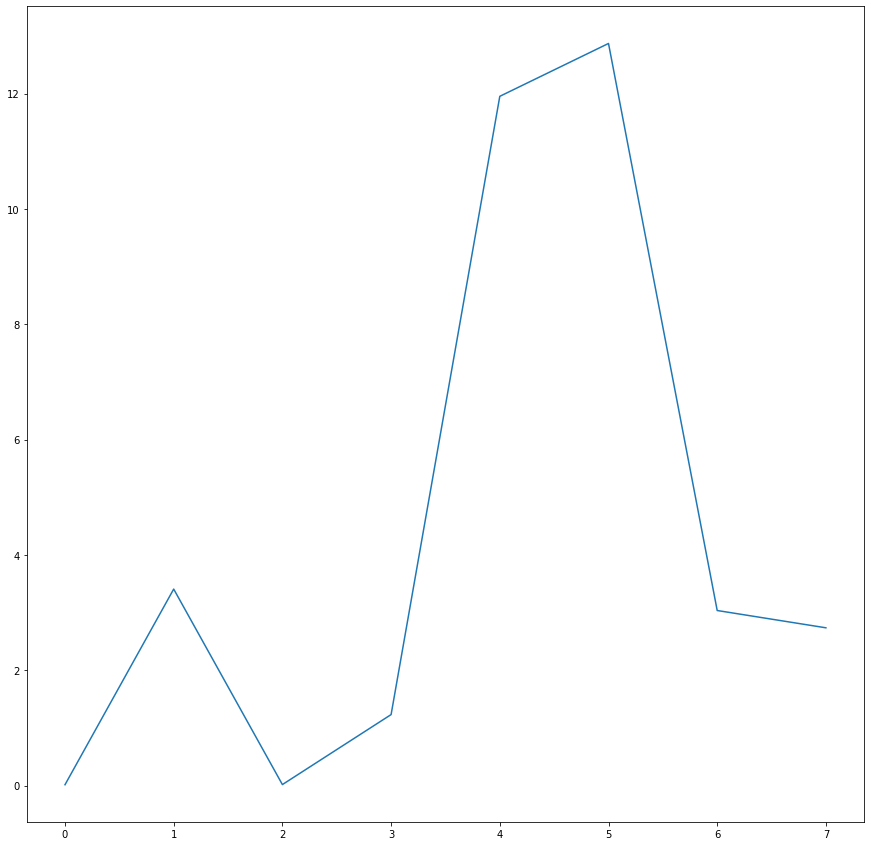

In [1]:
import time
%matplotlib inline
from deep_rl_ga.ga_env import GeneticAlgorithmEnv
from deep_rl_ga.agent import Agent
from deep_rl_ga.memory import Experience, ReplayMemory, extract_tensors
from deep_rl_ga.strategy import EpsilonGreedyStrategy
from deep_rl_ga.network import DQN
from deep_rl_ga.qvalues import QValues

from deap import benchmarks
from deap import tools

import torch
import torch.optim as optim
import torch.nn.functional as F

from itertools import count
import random

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
from deep_rl_ga.diversity import (
    Clusterer,
    fitness_max_mean_ratio_diversity,
    fitness_mean_min_ratio_diversity,
    gene_mean_std_diversity,
    gene_mean_unique_ratio_diversity,
    number_of_clusters_diversity,
)

# Genetic algorithm params
IND_SIZE = 3
LOW_BOUND = -5.12
UP_BOUND = 5.12
FITNESS_FUNCTION = benchmarks.rastrigin
SEARCH_SPACE_CENTER = np.array([(UP_BOUND - LOW_BOUND / 2) for _ in range(IND_SIZE)])
SEARCH_SPACE_DIAMETER = np.linalg.norm(np.array([UP_BOUND for _ in range(IND_SIZE)]) - np.array([LOW_BOUND for _ in range(IND_SIZE)]))

# Crossover + Mutation params
MATING_RATE = 0.3
INDIVIDUAL_MUTATION_RATE = 0.3

# Selection params
TOURNAMENT_SIZE = 3
TOP_BEST_SIZE = 10

INITIAL_POPULATION_SIZE = 150
MAX_EVALS = 10_000

RANDOM_SEED = 42

random.seed(
    RANDOM_SEED
    )
np.random.seed(
    RANDOM_SEED
    )

ACTIONS_SEL = [
    {'function': tools.selTournament, 'tournsize': TOURNAMENT_SIZE},
    {'function': tools.selBest, 'k': TOP_BEST_SIZE},
]

ACTIONS_CX = [
    {'function': tools.cxBlend, 'alpha': UP_BOUND},
    {'function': tools.cxTwoPoint},
]

ACTIONS_MU = [
    {'function': tools.mutGaussian, 'mu': 0, 'sigma': 1, 'indpb': INDIVIDUAL_MUTATION_RATE},
    {'function': tools.mutShuffleIndexes, 'indpb': INDIVIDUAL_MUTATION_RATE},
]


CLUSTERER = Clusterer()

N_CLUSTERS = 10

STAT_FUNCTIONS = [
    # ("max_fitness", lambda
    #     pop: np.max(
    #     [ind.fitness.values[0] for ind in pop]
    #     )),
    # ("min_fitness", lambda
    #     pop: np.min(
    #     [ind.fitness.values[0] for ind in pop]
    #     )),
    # ("fitness_std_range_diversity", lambda
    #     pop: np.std(
    #     [ind.fitness.values[0] for ind in pop]
    #     )),
    # ("number_of_clusters_diversity", number_of_clusters_diversity),  # This is very costly, takes 2x the total time it takes to cluster the population and evaluate other functions on each of the clusters
    # ("clusters_of_fitness_max_mean_ratio_diversity", CLUSTERER.clusters_of(
    #     fitness_max_mean_ratio_diversity
    # )),
    # ("clusters_of_fitness_mean_min_ratio_diversity", CLUSTERER.clusters_of(
    #     fitness_mean_min_ratio_diversity
    # )),
    # ("clusters_of_gene_mean_std_diversity", CLUSTERER.clusters_of(
    #     gene_mean_std_diversity
    # )),
    # ("clusters_of_gene_mean_unique_ratio_diversity", CLUSTERER.clusters_of(
    #     gene_mean_unique_ratio_diversity
    # )),
    # ("clusters_of_multiple_fns", CLUSTERER.clusters_of_fns([
    #     fitness_max_mean_ratio_diversity,
    #     fitness_mean_min_ratio_diversity,
    #     gene_mean_std_diversity,
    #     gene_mean_unique_ratio_diversity,
    #     lambda p: len(p) / INITIAL_POPULATION_SIZE,  # Cluster population size as part of initial population size
    #     lambda p: np.linalg.norm(np.mean(p, axis=0) - SEARCH_SPACE_CENTER) / SEARCH_SPACE_DIAMETER,  # Cluster centroid distance from the middle of search space; normalized by search space diameter
    # ], n_clusters=N_CLUSTERS, random_seed=RANDOM_SEED)),
]

# Neural network params
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.00033
target_update = 10
memory_size = 100_000
lr = 0.001
num_episodes = 3_000

save_every_num_episodes = 150

curr_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = GeneticAlgorithmEnv(
    num_dims=IND_SIZE,
    low_bound=LOW_BOUND,
    up_bound=UP_BOUND,
    fitness_fn=benchmarks.rastrigin,
    max_evals=MAX_EVALS,
    initial_population_size=INITIAL_POPULATION_SIZE,
    actions_sel=ACTIONS_SEL,
    actions_cx=ACTIONS_CX,
    actions_mu=ACTIONS_MU,
    stat_functions=STAT_FUNCTIONS,
    clusterer=CLUSTERER,
    device=curr_device,
)

episode_best_fitnesses = []
for episode in range(em.num_actions_available()):
    episode_best_fitnesses.append([])
    for seed in range(100):
        RANDOM_SEED = seed

        random.seed(
            RANDOM_SEED
            )
        np.random.seed(
            RANDOM_SEED
            )
        em.reset()
        for timestep in count():
            action = episode
            reward = em.take_action(torch.tensor([action], device=curr_device))  # this is a performance bottleneck, it takes 0.1seconds, almost 100% of the time required for a single timestep

            if em.done:
                # TODO: This should be a value that we want to track across episodes, e.x. number of generations before global optimum was found
                episode_best_fitnesses[-1].append(em.hof[0].fitness.values[0])
                print('Episode', len(episode_best_fitnesses), '\n')
                # plot(episode_best_fitnesses, 100)
                break

    # # Checkpoint
    # if episode > 0 and episode % save_every_num_episodes == 0:
    #     # Performance
    #     moving_averages = [np.mean(episode_best_fitnesses[i-100:i]) if i > 99 else np.mean(episode_best_fitnesses[:i]) for i, _ in enumerate(episode_best_fitnesses)]
    #     plt.plot(moving_averages)
    #     plt.savefig(f'moving_averages_{episode}_episodes.png')

    # TODO: This should be a value that we want to track across episodes, e.x. number of generations before global optimum was found
    # if get_moving_average(100, episode_best_fitnesses)[-1] <= 0.0001:
    #     break

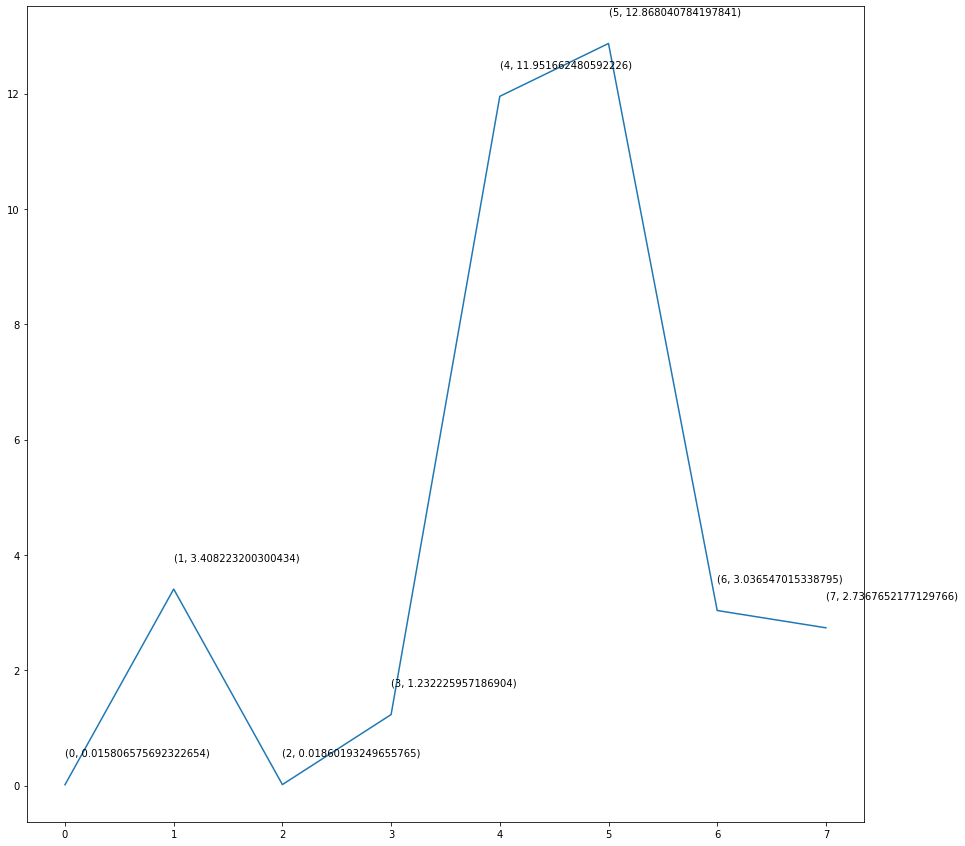

In [2]:
mean_over_100_seeds = np.mean(episode_best_fitnesses, axis=1)
plt.figure(figsize=(15,15))
plt.plot(mean_over_100_seeds)
for i, j in enumerate(mean_over_100_seeds):
   plt.text(i, j+0.5, '({}, {})'.format(i, j))
plt.savefig(f'mean_best_fitnesses_for_action_idx_over_100_seeds.png')